<a href="https://colab.research.google.com/github/juanmggb/maestria/blob/main/ml_batch/time_stepper_rk4_solver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RK4 solver

We optimizing the inflow rate it is not necessary to evaluate different initial conditions. Only those entered by the user. What we need is to evaluate different inflow rate profiles 

I could use an ANN to model the inglow rate as a function of time

In [ ]:
pip install pyDOE

In [ ]:
pip install torchdyn

In [10]:
from argparse import ArgumentParser
from numpy import double
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm
from pyDOE import lhs
import matplotlib.pyplot as plt
from torch.nn.functional import mse_loss
import numpy as np
import torch
from torchdyn.numerics import odeint
import pandas as pd
# from torchdyn.numerics.solvers import SolverTemplate

In [11]:
# Make device agnostic code 
device = "cuda" if torch.cuda.is_available() else "cpu"

In [12]:
#@title solver 
class SolverTemplate(nn.Module):
    def __init__(self, order, min_factor: float = 0.2, max_factor: float = 10, safety: float = 0.9):
        super().__init__()
        self.order = order
        self.min_factor = torch.tensor([min_factor])
        self.max_factor = torch.tensor([max_factor])
        self.safety = torch.tensor([safety])
        self.tableau = None

    def sync_device_dtype(self, x, t_span):
        "Ensures `x`, `t_span`, `tableau` and other solver tensors are on the same device with compatible dtypes"

        if isinstance(x, dict):
            proto_arr = x[list(x.keys())[0]]
        elif isinstance(x, torch.Tensor):
            proto_arr = x
        else:
            raise NotImplementedError(
                f"{type(x)} is not supported as the state variable")

        device = proto_arr.device

        if self.tableau is not None:
            c, a, bsol, berr = self.tableau
            self.tableau = c.to(proto_arr), [a.to(proto_arr) for a in a], bsol.to(
                proto_arr), berr.to(proto_arr)
        t_span = t_span.to(device)
        self.safety = self.safety.to(device)
        self.min_factor = self.min_factor.to(device)
        self.max_factor = self.max_factor.to(device)
        return x, t_span

    def step(self, f, x, t, dt, k1=None, args=None):
        pass

class DirectSolver(SolverTemplate):
    def __init__(self, dtype=torch.float32):
        super().__init__(order=1)
        self.dtype = dtype
        self.stepping_class = "fixed"

    def step(self, f, x, t, dt, k1=None, args=None):

        x_sol = f(t, x)
        return None, x_sol, None

class ResnetSolver(SolverTemplate):
    def __init__(self, step_size=None, dtype=torch.float32):
        super().__init__(order=1)
        self.dtype = dtype
        self.stepping_class = "fixed"

        self.step_size = 1 if step_size is None else step_size

    def step(self, f, x, t, dt, k1=None, args=None):
        
        x_sol = x + f(t, x) * self.step_size
        return None, x_sol, None

In [13]:
#@title bioreactor model
def inhibition_model(t, x):
    b = x[:, 0]
    s = x[:, 1]
    p = x[:, 2]

    # Kinetic parameters
    mu = 1.2 # 1/h
    ks = 280 # g/L
    Yxs = 0.2 
    Ypx = 4 
    ki = 0.3

    # Mass balances
    db = mu*(s / (ks + s + ki*s**2))*b 
    ds = -1/Yxs*mu*(s / (ks + s + ki*s**2))*b 
    dp = Ypx*mu*(s / (ks + s + ki*s**2))*b

    return torch.stack((db, ds, dp), dim=-1)

In [14]:
def create_initial_cond(n_training,
                         lower_limit_x,
                         delta_x,
                         lower_limit_s,
                         delta_s,
                         lower_limit_p,
                         delta_p):
    
    x0_train = (
        torch.tensor(lhs(3, n_training), device=device) 
    ) 
    x0_train[:,0] = x0_train[:,0] * delta_x + lower_limit_x # biomass (0.2-10.2)
    x0_train[:,1] = x0_train[:,1] * delta_s + lower_limit_s # substrate (0-40)
    x0_train[:,2] = x0_train[:,2] * delta_p + lower_limit_p # product (0-40)
    return x0_train 

1. Create initial conditions for training 
    * 100 initial conditions 
    * biomass concentrations goes from 0.2 to 10 g/L
    * substrate concentration goes from 0 to 40 g/L
    * product concentration goes from 0 to 40 g/L

In [15]:
# Initial condtions for training
x0_train = create_initial_cond(100, 0.2, 9.8, 0, 40, 0, 40)
print(x0_train[:5])
print(x0_train.shape)

tensor([[ 4.3547,  3.3397, 33.3054],
        [ 9.7643, 30.1467, 32.4063],
        [ 2.9940,  8.9014, 31.3824],
        [ 6.5623, 21.7969,  4.8754],
        [ 7.1495, 14.6307, 11.0416]], dtype=torch.float64)
torch.Size([100, 3])


2. Create initial conditions for validation 
    * 100 initial conditions 
    * biomass concentrations goes from 0.2 to 10 g/L
    * substrate concentration goes from 20 to 35 g/L
    * product concentration goes from 0 to 0 g/L

In [16]:
# Initial conditions to model validation
# x0_validate = create_initial_cond(10, 0.2, 10, 0, 40, 0, 40)
x0_validate = create_initial_cond(10, 1, 5, 15, 20, 0, 0)
print(x0_validate[:5])
print(x0_validate.shape)

tensor([[ 3.6934, 18.4576,  0.0000],
        [ 5.3615, 24.1154,  0.0000],
        [ 2.1449, 26.4905,  0.0000],
        [ 3.2893, 31.9055,  0.0000],
        [ 1.5572, 34.1662,  0.0000]], dtype=torch.float64)
torch.Size([10, 3])


In [17]:
def create_time_span(start_time, end_time, step_size):
    ε = 1e-10 
    t_span = torch.arange(
        start_time, 
        end_time + ε,
        step_size
    )
    return t_span

3. Create time span for training
    * Time span for training is of one hour

4. Create time span for validations 
    * Time span for validations is of sixty hours

In [18]:
# training time are time intervals of 1 hour
t_span_train = create_time_span(0, 1, 1)
# validation time are time intervals of 60 hours
t_span_validate = create_time_span(0, 60, 1)

5. Generate training trajectories
    * Each training trajectory consists of two observations, the initial condition and one step haead 

In [19]:
# Calculate state at hour 1 with training initial conditions
# This is equivalen to experimental data
_, x_train = odeint(inhibition_model, x0_train, t_span_train, solver="rk4")

In [20]:
# Function to plot trajectory
def plot_trajectory(n, trajectories):
    if n == 0:
        plt.plot(trajectories[:, n, 0], label='biomass', color="lightgreen")
        plt.plot(trajectories[:, n, 1], label='substrate', color="#F97306")
        plt.plot(trajectories[:, n, 2], label='product', color="#069AF3")
    else: 
        plt.plot(trajectories[:, n, 0], color="lightgreen")
        plt.plot(trajectories[:, n, 1], color="#F97306")
        plt.plot(trajectories[:, n, 2], color="#069AF3")


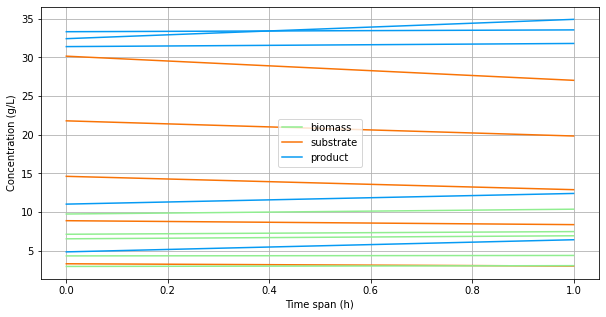

In [21]:
# Plot trajectory n from 100 training trajectories
plt.figure(figsize=(10, 5))
for i in range(5):    
    plot_trajectory(i, x_train)
plt.xlabel('Time span (h)')
plt.ylabel('Concentration (g/L)')
plt.grid()
plt.legend()
plt.show()

6. Generate validations trajectories
    * Each validations trajectory consists of sixty one observations, the initial contition and sixty steps haead

In [22]:
# Calculate trajectory for initial conditions in validation data
_, x_validate = odeint(inhibition_model, x0_validate, t_span_validate, solver="rk4")

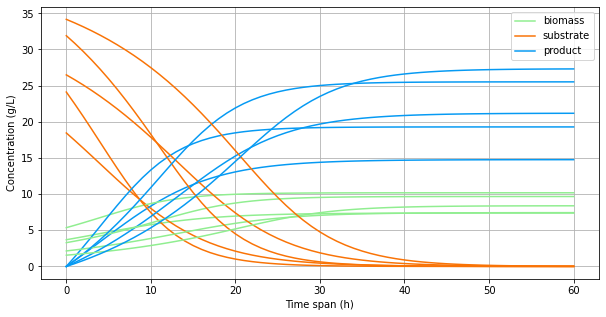

In [23]:
# Plot trajectory n from 100 training trajectories
plt.figure(figsize=(10, 5))
for i in range(5):    
    plot_trajectory(i, x_validate)
plt.xlabel('Time span (h)')
plt.ylabel('Concentration (g/L)')
plt.grid()
plt.legend()
plt.show()

7. Create ANN model
    * The input layers contains three neurons. It is a simple linear layer without activation function 
    * There exist eight hidden layers, each with thirty two neurons. Each hidden layer consist of a linear layer with a softplus acttivation function 
    * the output layer has three neurons and it is a simple linear layr without activation function
    * The weights and biases are randomly initialized 

In [24]:
def fnn_model(input_dim, 
              output_dim, 
              hidden_dim, 
              hidden_layers):
    layers = []
    layers.append(nn.Linear(input_dim, hidden_dim))
    for _ in range(hidden_layers):
        layers.append(nn.Linear(hidden_dim, hidden_dim)) 
        layers.append(nn.Softplus()) 
    layers.append(nn.Linear(hidden_dim, output_dim))
    net = nn.Sequential(*layers) 
    net.to('cpu').double()

    for m in net.modules():
        if type(m) == nn.Linear:
            # Initialize the weights of the Linear module using xavier_uniform_
            nn.init.xavier_uniform_(m.weight)
    return net

In [25]:
# Create model
net = fnn_model(3, 3, 32, 8)

8. The training algorithm is Adam

In [26]:
# training algorithm
optimizer = Adam(net.parameters()) 

In [27]:
import time 

9. During training
    * The training occurs for 2000 epochs 
    * The loss function is MSE
    * There is no inference phase during training 

In [28]:
start_time = time.time()
# training
losses = []

epochs = 2000

for epoch in tqdm(range(epochs)): 

    net.train()

    # 1. Forward pass
    _, x_pred_train = odeint(
        lambda t, x: net(x),
        x0_train,
        t_span_train, 
        solver='rk4'
    )

    # 2. Calculate loss
    loss = mse_loss(x_pred_train, x_train) 

    # 3. Zero grad
    optimizer.zero_grad() 
    
    # 4. Backward pass
    loss.backward()
    losses.append(loss.item())

    # 5. Update weights and biases
    optimizer.step() 

    # Validation data
    # net.eval()
    # with torch.inference_mode():

    #     # 1. Forward pass
    #     _, x_pred_validate = odeint(
    #         lambda t, x: net(x), 
    #         x0_validate, 
    #         t_span_validate, 
    #         solver='rk4'
    #     )

    #     # 2. Calculate loss
    #     loss_val = mse_loss(x_pred_validate, x_validate) 
    
    if epoch % 50 == 0:

        print(f"Epoch: {epoch} | Training loss: {loss}")
end_time = time.time()

  0%|          | 9/2000 [00:00<00:42, 46.83it/s]

Epoch: 0 | Training loss: 1.6095159337341243


  3%|▎         | 61/2000 [00:00<00:21, 89.74it/s]

Epoch: 50 | Training loss: 0.12844523348270243


  6%|▌         | 118/2000 [00:01<00:17, 104.58it/s]

Epoch: 100 | Training loss: 0.0023320898631006472


  8%|▊         | 159/2000 [00:01<00:23, 78.91it/s]

Epoch: 150 | Training loss: 0.0006316180435120356


 11%|█         | 215/2000 [00:02<00:18, 96.02it/s]

Epoch: 200 | Training loss: 0.0003510437953764827


 14%|█▎        | 270/2000 [00:03<00:16, 104.12it/s]

Epoch: 250 | Training loss: 0.00026063095764614443


 16%|█▌        | 316/2000 [00:03<00:15, 107.03it/s]

Epoch: 300 | Training loss: 0.00021436907046368248


 18%|█▊        | 365/2000 [00:04<00:21, 75.93it/s]

Epoch: 350 | Training loss: 0.00019640430490132653


 21%|██        | 411/2000 [00:04<00:26, 58.98it/s]

Epoch: 400 | Training loss: 0.00016307736917651596


 23%|██▎       | 457/2000 [00:05<00:30, 50.78it/s]

Epoch: 450 | Training loss: 0.00018973180467088874


 26%|██▌       | 510/2000 [00:06<00:26, 56.39it/s]

Epoch: 500 | Training loss: 0.00013028483853807325


 28%|██▊       | 558/2000 [00:07<00:23, 62.14it/s]

Epoch: 550 | Training loss: 0.0001172291409684435


 30%|███       | 605/2000 [00:08<00:24, 56.47it/s]

Epoch: 600 | Training loss: 0.0001720395965383434


 33%|███▎      | 657/2000 [00:09<00:31, 42.03it/s]

Epoch: 650 | Training loss: 0.00010017083892322265


 35%|███▌      | 707/2000 [00:11<00:32, 39.56it/s]

Epoch: 700 | Training loss: 9.014297286695608e-05


 38%|███▊      | 760/2000 [00:12<00:24, 50.30it/s]

Epoch: 750 | Training loss: 8.189407675203958e-05


 40%|████      | 810/2000 [00:13<00:23, 50.72it/s]

Epoch: 800 | Training loss: 8.104959066088952e-05


 43%|████▎     | 857/2000 [00:14<00:25, 45.11it/s]

Epoch: 850 | Training loss: 6.932580609357425e-05


 45%|████▌     | 907/2000 [00:15<00:17, 62.85it/s]

Epoch: 900 | Training loss: 6.130062860803943e-05


 48%|████▊     | 958/2000 [00:16<00:19, 53.99it/s]

Epoch: 950 | Training loss: 5.4318105904680585e-05


 50%|█████     | 1000/2000 [00:16<00:19, 51.66it/s]

Epoch: 1000 | Training loss: 0.00014956315267747317


 53%|█████▎    | 1058/2000 [00:18<00:16, 57.37it/s]

Epoch: 1050 | Training loss: 4.5968709695744735e-05


 55%|█████▌    | 1107/2000 [00:19<00:32, 27.37it/s]

Epoch: 1100 | Training loss: 4.1761156093694863e-05


 58%|█████▊    | 1153/2000 [00:21<00:32, 25.91it/s]

Epoch: 1150 | Training loss: 8.367888582818112e-05


 60%|██████    | 1207/2000 [00:22<00:18, 43.46it/s]

Epoch: 1200 | Training loss: 3.73215214697006e-05


 63%|██████▎   | 1261/2000 [00:23<00:14, 51.71it/s]

Epoch: 1250 | Training loss: 3.4261964464801666e-05


 66%|██████▌   | 1311/2000 [00:25<00:15, 44.67it/s]

Epoch: 1300 | Training loss: 0.0014474008760801357


 68%|██████▊   | 1360/2000 [00:26<00:13, 45.89it/s]

Epoch: 1350 | Training loss: 4.125001896141832e-05


 70%|███████   | 1407/2000 [00:27<00:20, 28.32it/s]

Epoch: 1400 | Training loss: 3.0352267224723293e-05


 73%|███████▎  | 1460/2000 [00:28<00:10, 52.41it/s]

Epoch: 1450 | Training loss: 2.8316967136642125e-05


 75%|███████▌  | 1505/2000 [00:29<00:12, 38.95it/s]

Epoch: 1500 | Training loss: 2.6663057567850855e-05


 78%|███████▊  | 1557/2000 [00:30<00:09, 48.76it/s]

Epoch: 1550 | Training loss: 0.001386387649577289


 80%|████████  | 1605/2000 [00:31<00:07, 49.67it/s]

Epoch: 1600 | Training loss: 3.623676089792062e-05


 84%|████████▎ | 1670/2000 [00:32<00:04, 82.42it/s]

Epoch: 1650 | Training loss: 2.5414270128181255e-05


 86%|████████▌ | 1712/2000 [00:33<00:02, 97.51it/s]

Epoch: 1700 | Training loss: 2.376257414374355e-05


 88%|████████▊ | 1770/2000 [00:33<00:02, 105.65it/s]

Epoch: 1750 | Training loss: 2.2517564216645015e-05


 91%|█████████ | 1815/2000 [00:34<00:01, 105.47it/s]

Epoch: 1800 | Training loss: 2.1430423708563308e-05


 93%|█████████▎| 1859/2000 [00:34<00:01, 94.72it/s] 

Epoch: 1850 | Training loss: 2.1025405516886126e-05


 96%|█████████▌| 1915/2000 [00:35<00:00, 103.07it/s]

Epoch: 1900 | Training loss: 7.985300387505296e-05


 98%|█████████▊| 1960/2000 [00:35<00:00, 102.90it/s]

Epoch: 1950 | Training loss: 2.2479430561124585e-05


100%|██████████| 2000/2000 [00:36<00:00, 55.40it/s] 


10. The time required for training withoput inference phase was 19.022 seconds

11. The minimum training loss functions value was 1.508e-5

In [29]:
total_time = end_time - start_time
print(f"Total time: {total_time:.3f}s")

Total time: 36.111s


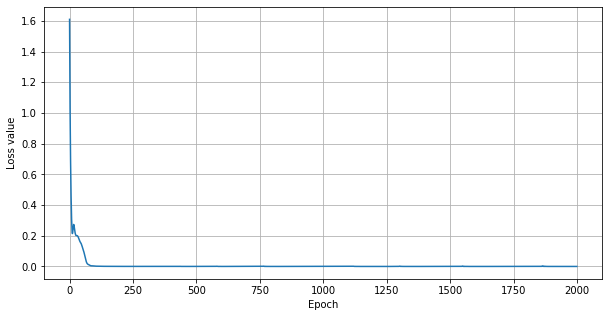

In [30]:
# Plot loss evolution 
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.grid()
plt.show()

In [31]:
# Make predictions 
net.eval()
with torch.inference_mode():
    _, x_pred_validate = odeint(lambda t, x: net(
        x), x0_validate, t_span_validate, solver='rk4'
    ) 

In [32]:
print(x_pred_validate.shape)

torch.Size([61, 10, 3])


12. The minimum validations loss function value was 0.149 

In [33]:
mse_loss(x_pred_validate, x_validate) 

tensor(0.0467, dtype=torch.float64)

Validations loss: 0.1491

In [34]:
# In order to plot predictions we need a numpy array
x_pred_validate = x_pred_validate.detach().numpy()

In [35]:
def plot_predictions(n=0):

    print("Validation", n)

    # Create figure
    plt.figure(figsize = (25,5))

    # plot biomass
    plt.subplot(131)
    plt.plot(t_span_validate, 
        x_validate[:, n, 0], 
        color="#069AF3", label = 'Mechanistic model', linewidth = 5)

    # plot substrate
    plt.subplot(132)
    plt.plot(
        t_span_validate, 
        x_validate[:, n, 1], 
        color="#F97306", label = 'Mechanistic model', linewidth = 5)

    # plot ethanol
    plt.subplot(133)
    plt.plot(t_span_validate, 
            x_validate[:, n, 2], 
            color="lightgreen", label = 'Mechanistic model', linewidth = 5)


    # plot biomass
    plt.subplot(131)
    plt.plot(
        t_span_validate,
        x_pred_validate[:, n, 0], label = 'ANN', 
        linestyle="dashed",
        color="#069AF3", linewidth = 5)
    plt.grid()
    plt.xlabel("Time (h)", size = 20)
    plt.ylabel("Concentration (g/L)", size = 20)
    plt.title("Biomass", size = 20)
    plt.legend(fontsize = 20)

    # plot substrate
    plt.subplot(132)
    plt.plot(
        t_span_validate,
        x_pred_validate[:, n, 1], label = 'ANN', 
        linestyle="dashed",
        color='#F97306', linewidth = 5)
    plt.grid()
    plt.xlabel("Time (h)", size = 20)
    plt.ylabel("Concentration (g/L)", size = 20)
    plt.title("Substrate", size = 20)
    plt.legend(fontsize = 20)

    # plot ethanol
    plt.subplot(133)
    plt.plot(
        t_span_validate,
        x_pred_validate[:, n, 2], label = 'ANN', 
        linestyle="dashed",
        color="lightgreen", linewidth = 5)

    plt.grid()
    plt.xlabel("Time (h)", size = 20)
    plt.ylabel("Concentration (g/L)", size = 20)
    plt.title("Ethanol", size = 20)
    plt.legend(fontsize = 20)
    plt.show()

Validation 0


<ipython-input-35-3177a068ea55>:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(131)
<ipython-input-35-3177a068ea55>:42: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(132)
<ipython-input-35-3177a068ea55>:55: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and return

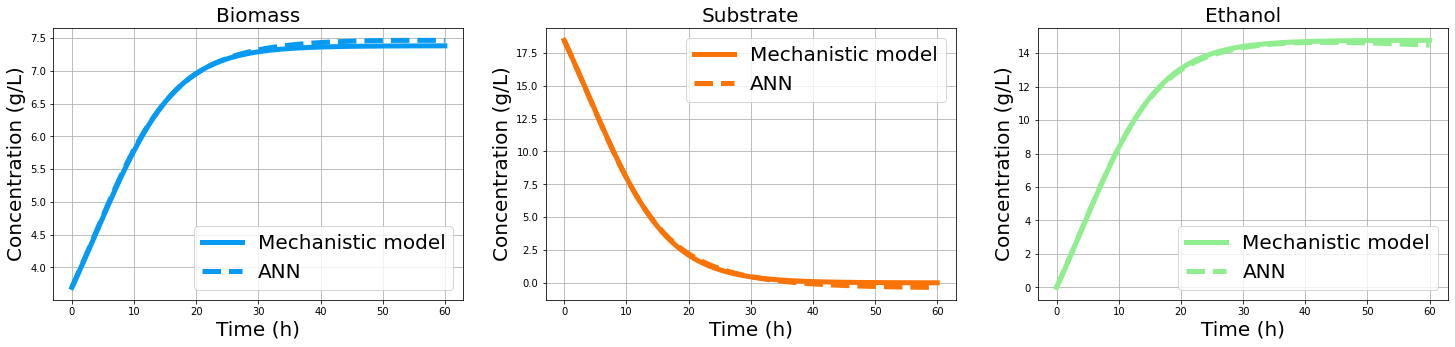

Validation 1


<ipython-input-35-3177a068ea55>:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(131)
<ipython-input-35-3177a068ea55>:42: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(132)
<ipython-input-35-3177a068ea55>:55: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and return

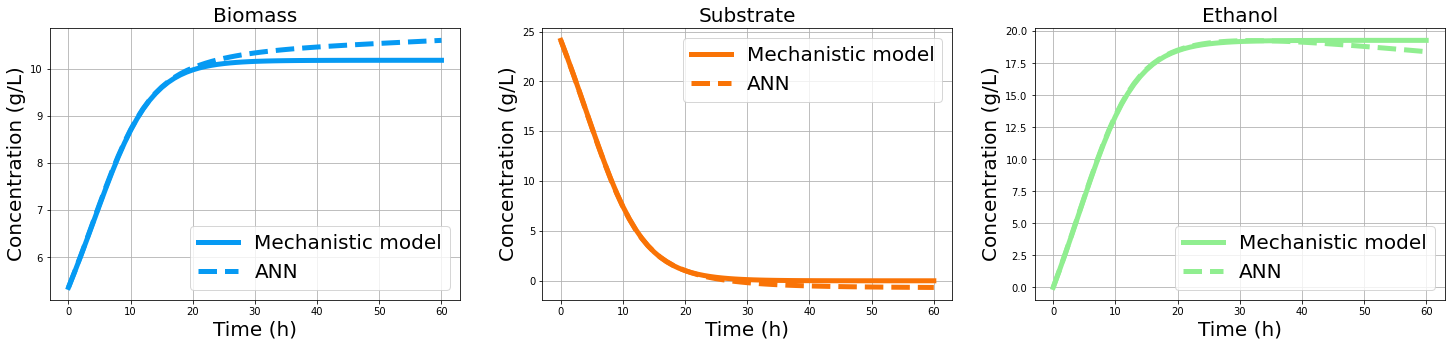

Validation 2


<ipython-input-35-3177a068ea55>:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(131)
<ipython-input-35-3177a068ea55>:42: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(132)
<ipython-input-35-3177a068ea55>:55: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and return

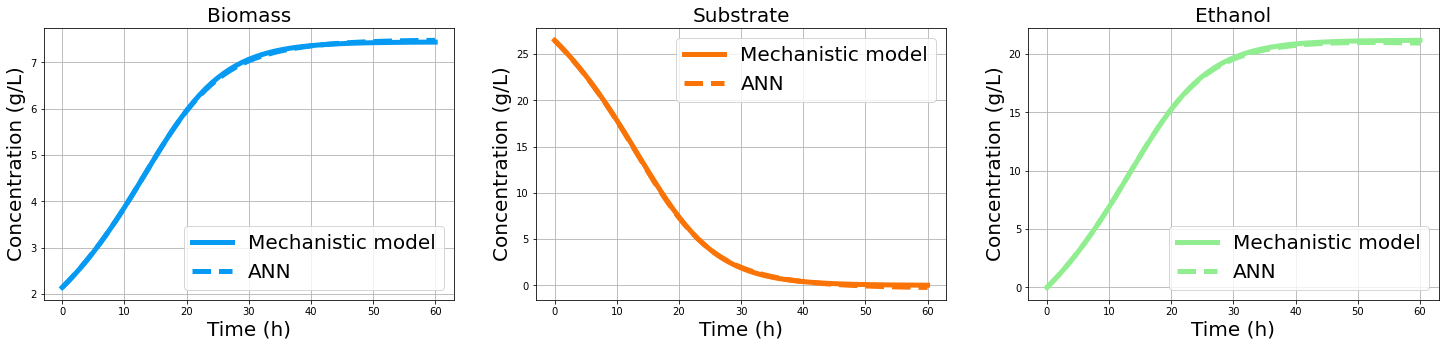

Validation 3


<ipython-input-35-3177a068ea55>:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(131)
<ipython-input-35-3177a068ea55>:42: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(132)
<ipython-input-35-3177a068ea55>:55: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and return

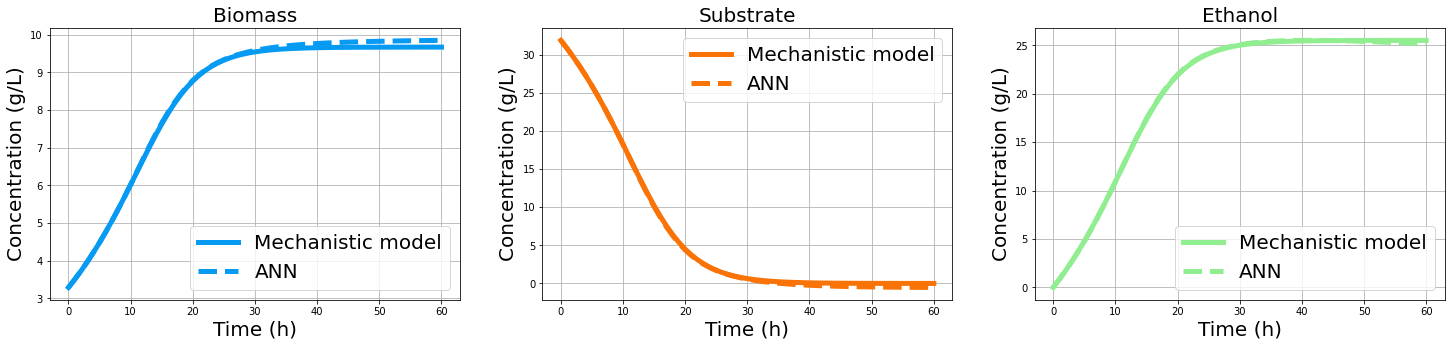

Validation 4


<ipython-input-35-3177a068ea55>:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(131)
<ipython-input-35-3177a068ea55>:42: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(132)
<ipython-input-35-3177a068ea55>:55: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and return

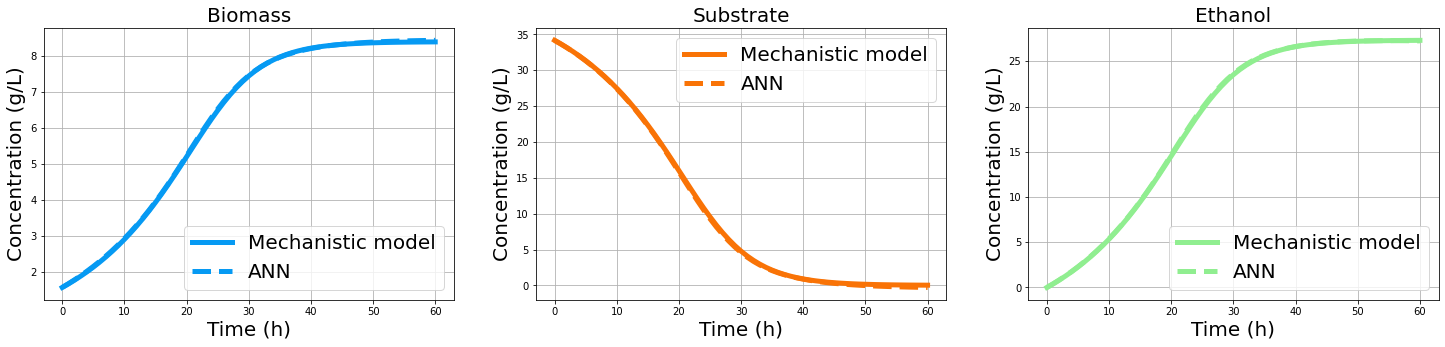

Validation 5


<ipython-input-35-3177a068ea55>:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(131)
<ipython-input-35-3177a068ea55>:42: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(132)
<ipython-input-35-3177a068ea55>:55: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and return

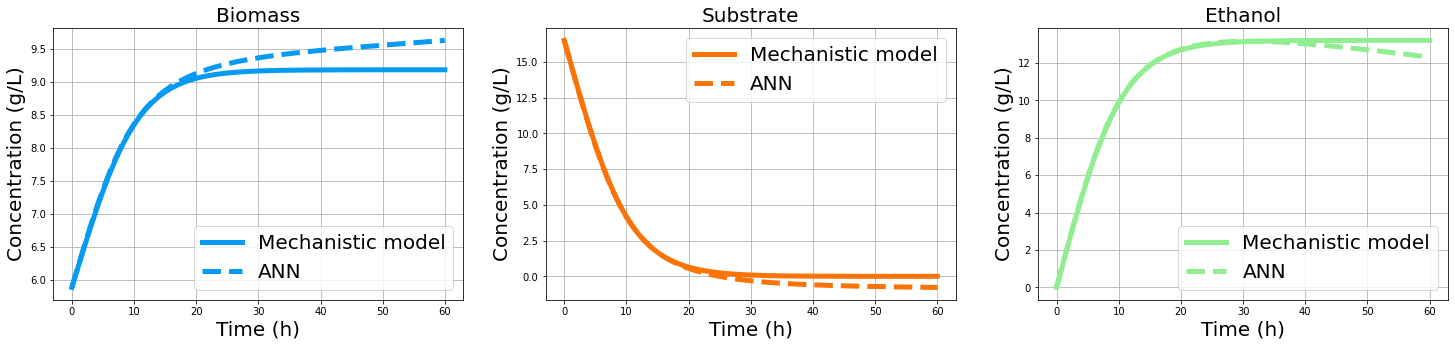

Validation 6


<ipython-input-35-3177a068ea55>:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(131)
<ipython-input-35-3177a068ea55>:42: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(132)
<ipython-input-35-3177a068ea55>:55: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and return

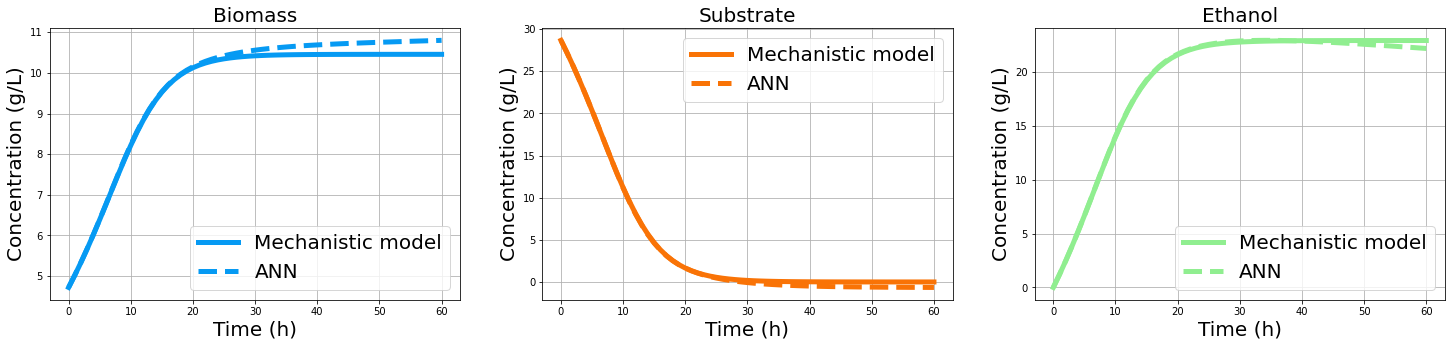

Validation 7


<ipython-input-35-3177a068ea55>:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(131)
<ipython-input-35-3177a068ea55>:42: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(132)
<ipython-input-35-3177a068ea55>:55: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and return

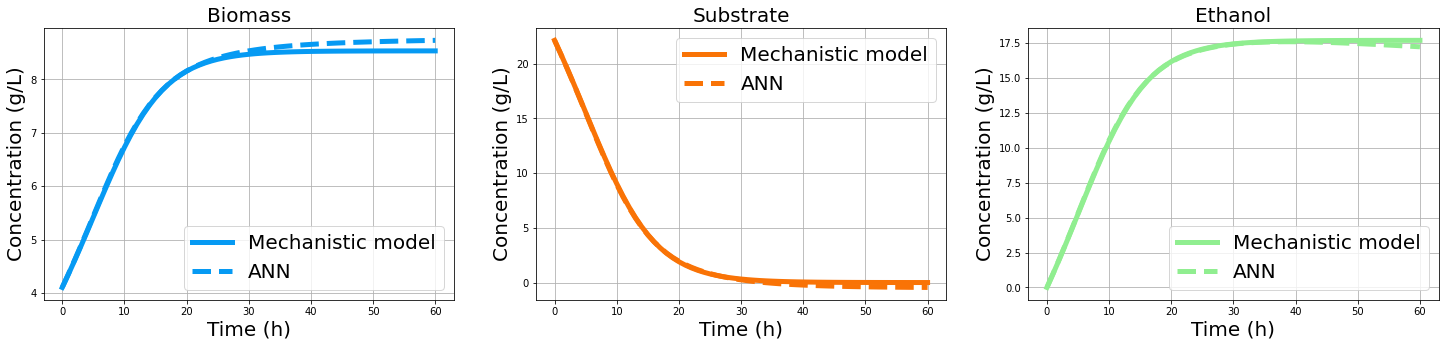

Validation 8


<ipython-input-35-3177a068ea55>:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(131)
<ipython-input-35-3177a068ea55>:42: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(132)
<ipython-input-35-3177a068ea55>:55: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and return

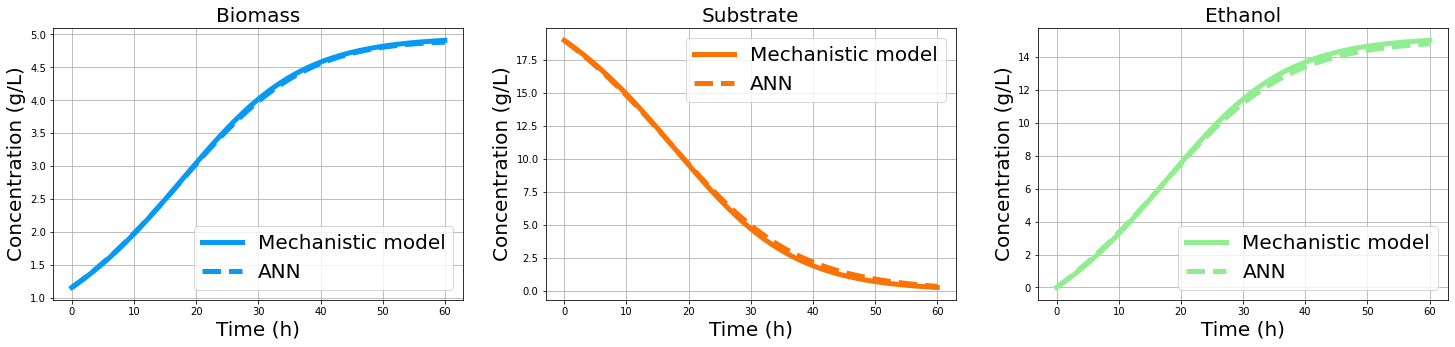

Validation 9


<ipython-input-35-3177a068ea55>:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(131)
<ipython-input-35-3177a068ea55>:42: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(132)
<ipython-input-35-3177a068ea55>:55: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and return

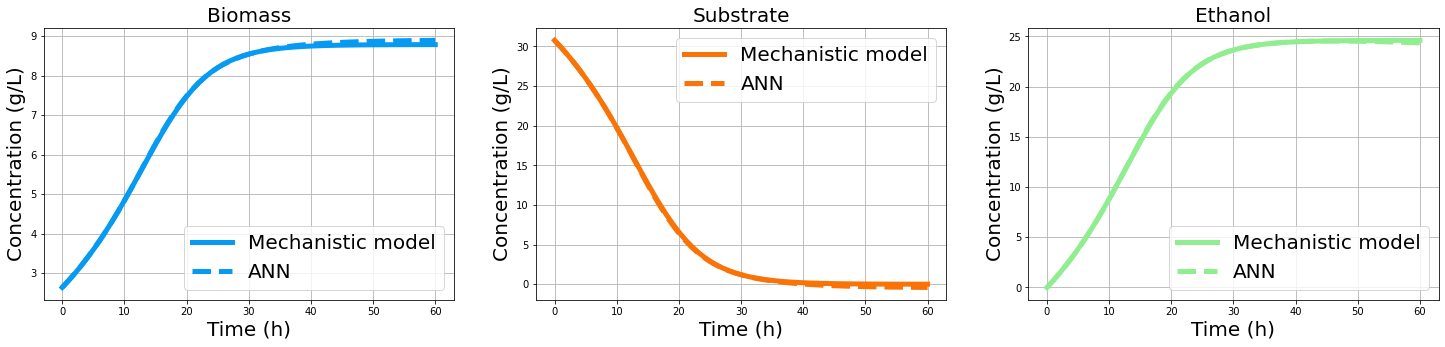

In [36]:
for i in range(10):
    plot_predictions(i)